# Vehicle Detection

## Color Features

In [1]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

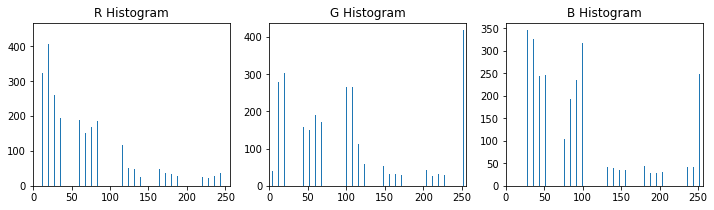

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('test_images/cutouts/car1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')

fig.savefig("output_images/colour_hist.jpg")
plt.show()

## Color Spaces

In [3]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        conv = eval("cv2.RGB2"+"color_space")
        img = cv2.cvtColor(img, conv);
    features = cv2.resize(img, size).ravel()
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    # features = img.ravel() # Remove this line!
    # Return the feature vector
    return features

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb, ax, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


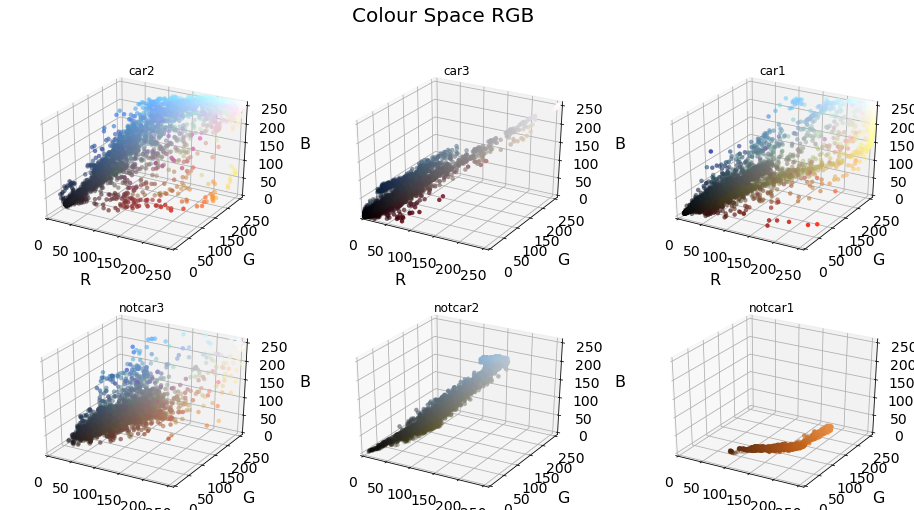

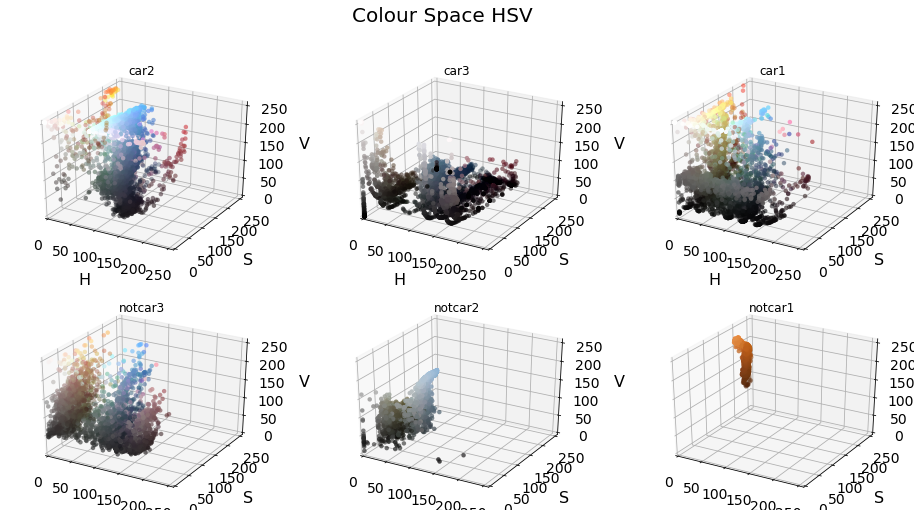

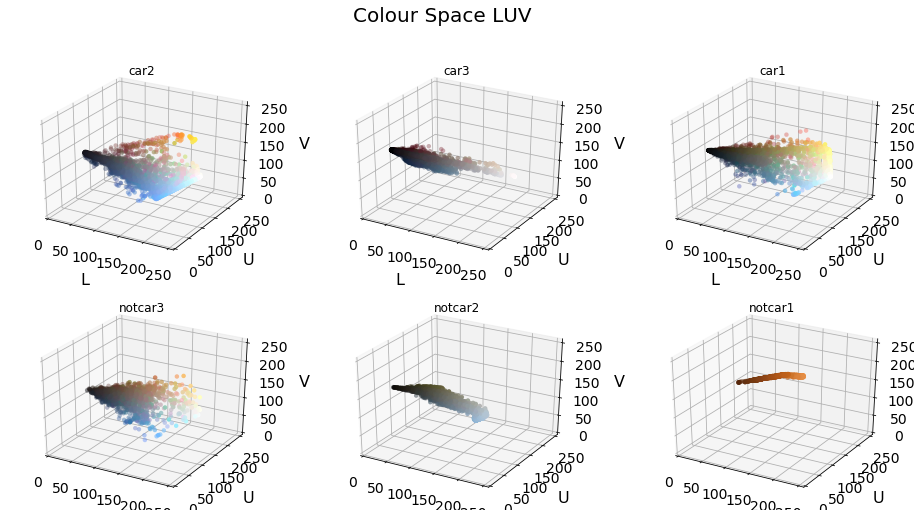

In [5]:
from glob import glob
from os import path

# Read a color image
cars = glob("test_images/cutouts/car*")
notcars = glob("test_images/cutouts/notcar*.png")

imgsets = (cars, notcars)

for colour_space in ("RGB", "HSV", "LUV"):
    fig = plt.figure(figsize=(16, 8))
    for i, imgset in enumerate(imgsets):
        for j, fn in enumerate(imgset):
            img =  cv2.imread(fn)

            # Select a small fraction of pixels to plot by subsampling it
            scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
            img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

            # Convert subsampled image to desired color space(s)
            img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
            img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
            conv = eval("cv2.COLOR_BGR2"+colour_space)
            img_small_conv = cv2.cvtColor(img_small, conv)

            # Create 3D axes
            ax = fig.add_subplot(len(imgsets), len(imgset), i*len(imgset)+j+1, projection='3d')
            plt.title(path.basename(fn).split('.')[0])

            # Plot and show
            plot3d(img_small_conv, img_small_rgb, ax, axis_labels=list(colour_space))
    fig.suptitle('Colour Space ' + colour_space, fontsize=20)
    fig.savefig("output_images/colour_space_"+ colour_space.lower() + "_features.jpg")

plt.show()

In [6]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        conv = eval("cv2.RGB2"+"color_space")
        img = cv2.cvtColor(img, conv);
    features = cv2.resize(img, size).ravel()
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    # features = img.ravel() # Remove this line!
    # Return the feature vector
    return features

## Hog Features

In [7]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        rv = hog(img, orient, 
                 (pix_per_cell,pix_per_cell),
                 (cell_per_block, cell_per_block),
                 visualise=vis,
                 feature_vector=feature_vec)
        features = rv[0]
        hog_image = rv[1]
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orient, pix_per_cell, cell_per_block, visualise=vis, feature_vector=feature_vec)
        return features

/Users/leozhou/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


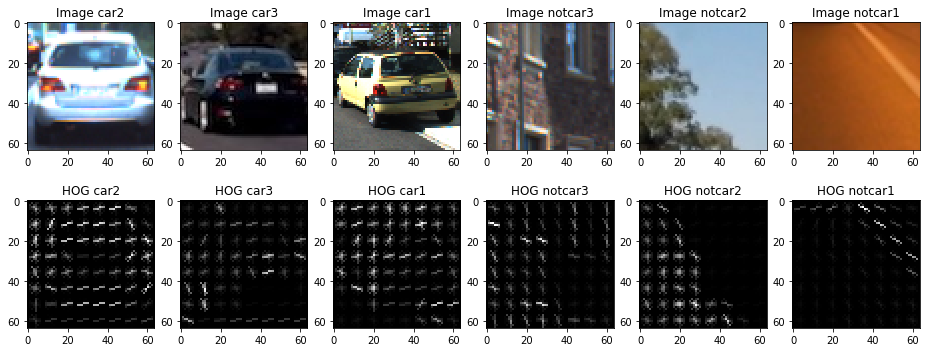

In [8]:
imgset = cars + notcars

fig = plt.figure(figsize=(16, 6))

for i, fn in enumerate(imgset):
    # Read in the image
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    # Plot the examples
    plt.subplot(2, len(imgset), i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Image ' + path.basename(fn).split('.')[0])

    plt.subplot(2, len(imgset), len(imgset)+i+1)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG ' + path.basename(fn).split('.')[0])
fig.savefig("output_images/hog_features.jpg")
plt.show()


## Combine and Normalize Features

In [9]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for fn in imgs:
        if isinstance(imgs[0], str):
            img = cv2.imread(fn)
            if cspace != "BGR":
                conv = eval("cv2.COLOR_BGR2" + cspace)
                img = cv2.cvtColor(img, conv)
        else:
            img = fn
            if cspace != "RGB":
                conv = eval("cv2.COLOR_RGB2" + cspace)
                img = cv2.cvtColor(img, conv)

        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        c_features = bin_spatial(img, size=spatial_size)
        h_features = color_hist(img, nbins=hist_bins, bins_range=hist_range)
        hog_features = get_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY),
                                        orient, 
                                        (pix_per_cell, pix_per_cell),
                                        (cell_per_block, cell_per_block),
                                        vis=False,
                                        feature_vec=True)

#         print(img.shape, len(c_features), len(h_features), len(hog_features))
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
        features.append(np.concatenate((c_features, h_features, hog_features)))
    # Return list of feature vectors
    return features

/Users/leozhou/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(4932,) (4932,)
(4932,) (4932,)
(4932,) (4932,)


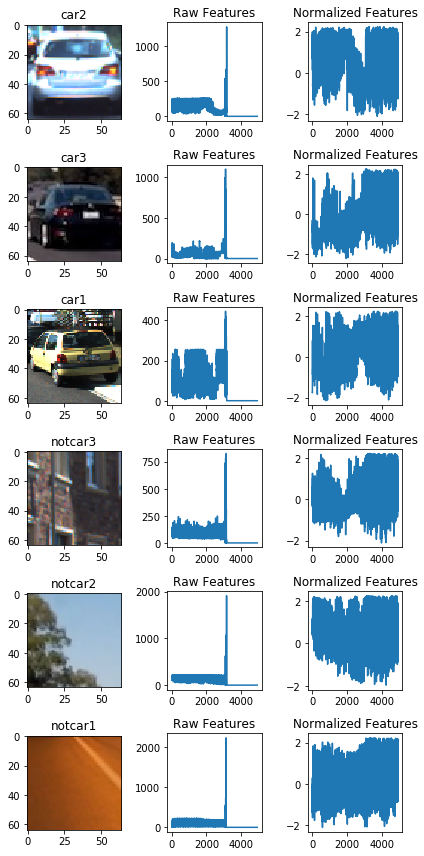

In [10]:
from sklearn.preprocessing import StandardScaler

car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

# Create an array stack of feature vectors
for i in range(len(car_features)):
    print(car_features[i].shape, notcar_features[i].shape)
X = np.vstack((car_features, notcar_features))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

row = len(cars+notcars)
col = 3
i = 0
fig = plt.figure(figsize=(6,2*row))

# plot
for car_ind in range(row):
    # Plot an example of raw and scaled features
    img = mpimg.imread((cars+notcars)[car_ind])
    img_name = path.basename((cars+notcars)[car_ind]).split('.')[0]

    i += 1
    plt.subplot(row, col, i)
    plt.imshow(img)
    plt.title(img_name)

    i += 1
    plt.subplot(row, col, i)
    plt.plot(X[car_ind])
    plt.title('Raw Features')

    i += 1
    plt.subplot(row, col, i)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

fig.savefig("output_images/normalised_features.jpg".format(img_name))
plt.show()

## Data Preparation

In [11]:
clahe = cv2.createCLAHE(clipLimit=2.0)

def equalise_hist(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    channels = cv2.split(img)
    channels[0] = clahe.apply(channels[0])
    img = cv2.merge(channels)
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

In [12]:
from sys import getsizeof
fn_car = glob("data/vehicles/*/*")
fn_notcar = glob("data/non-vehicles/*/*")
fn_all_cars = fn_car +  fn_notcar

w,h,d = cv2.imread(fn_car[0]).shape
data_car = np.zeros((len(fn_car), w, h, d), dtype=np.uint8)
data_notcar = np.zeros((len(fn_notcar), w, h, d), dtype=np.uint8)
i = j =0

for fn in fn_all_cars:
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = equalise_hist(img)

    if "non-vehicles" in fn:
        data_notcar[j] = img
        j += 1
    else:
        data_car[i] = img
        i += 1

print(getsizeof(data_car), getsizeof(data_notcar))
print(data_car.shape, data_notcar.shape)

108036240 110198928
(8792, 64, 64, 3) (8968, 64, 64, 3)


## Build a Classifier

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
import time
from sklearn.svm import LinearSVC

spatial = 8
histbin = 512
cspace = 'LUV'
hist_range = (0, 256)
orient=16
pix_per_cell=8
cell_per_block=2

car_features = extract_features(data_car, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(data_notcar, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

/Users/leozhou/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svr = LinearSVC()
parameters = {'C':[0.1, 10]}
# svc = GridSearchCV(svr, parameters)
svc = svr
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

# print("best C value:", svc.best_params_)

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Training Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 8 and 512 histogram bins
Feature vector length: 4864
9.24 Seconds to train SVC...
Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9924
My SVC predicts:      [ 0.  0.  1.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  0.  0.  0.]
0.00124 Seconds to predict 10 labels with SVC


/Users/leozhou/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(17936, 4864)
253 14
255 12
248 12
146 1
129 46
252 58


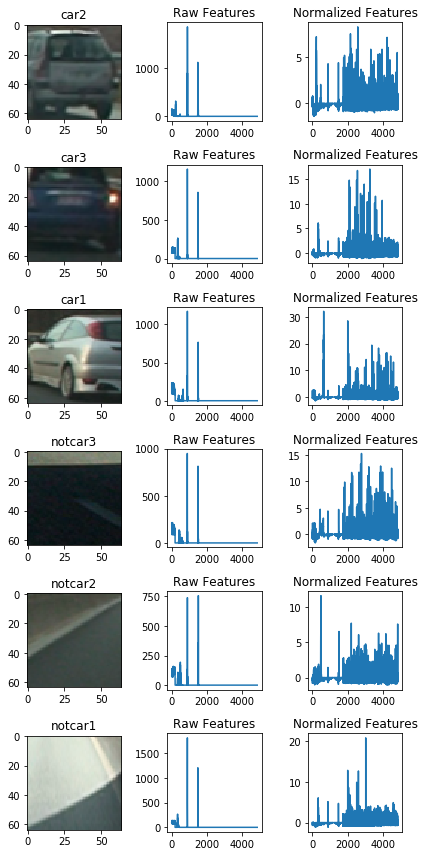

In [15]:
from sklearn.preprocessing import StandardScaler

car_features = extract_features(data_notcar, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(data_notcar, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(scaled_X.shape)

row = 6
col = 3
i = 0
fig = plt.figure(figsize=(6,2*row))

# plot
for car_ind in range(row):
    # Plot an example of raw and scaled features
#     print( np.vstack((data_car[0:3],data_notcar[0:3]))[car_ind].shape)
    img = np.vstack((data_car[0:3],data_notcar[0:3]))[car_ind]
    print(np.max(img), np.min(img))
    img_name = path.basename((cars+notcars)[car_ind]).split('.')[0]

    i += 1
    plt.subplot(row, col, i)
    plt.imshow(img.astype(np.uint8))
    plt.title(img_name)

    i += 1
    plt.subplot(row, col, i)
    plt.plot(X[car_ind])
    plt.title('Raw Features')

    i += 1
    plt.subplot(row, col, i)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
plt.show()

## Sliding Windows

Number of windows: 563


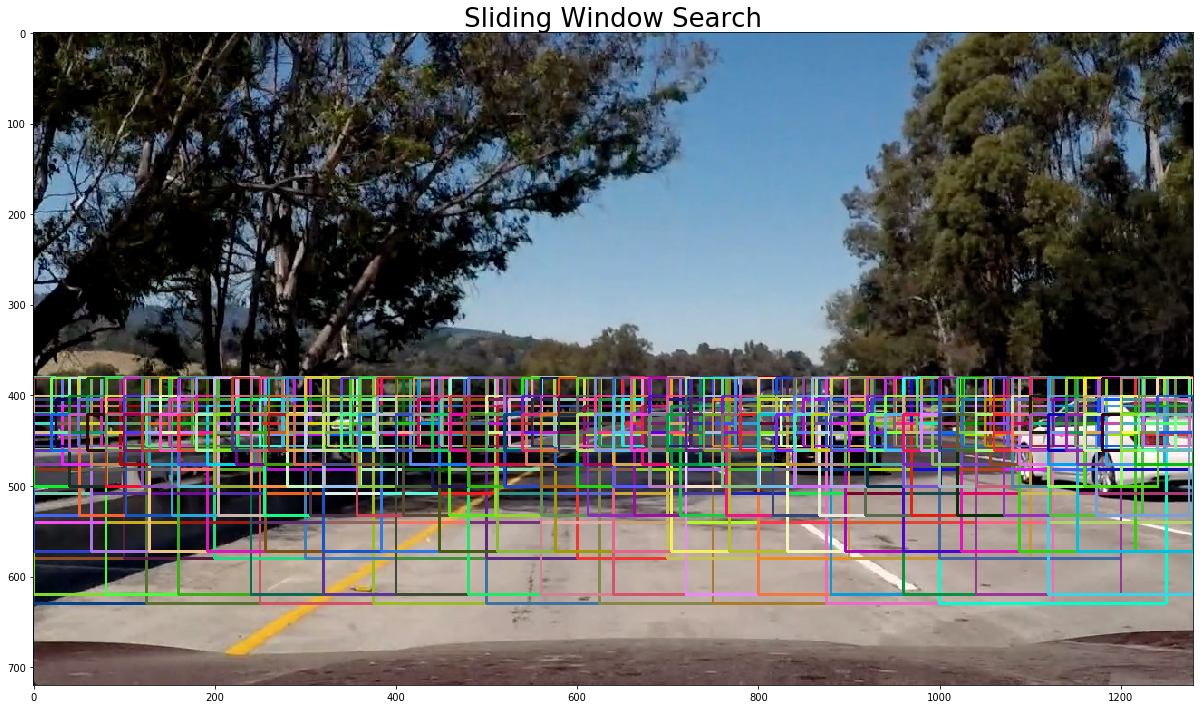

In [67]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == "random":
            c = np.random.randint(255, size=3).tolist()
        else:
            c = color
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], c, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    if x_start_stop[0] == None:
        x_start = 0
    else:
        x_start = x_start_stop[0]

    if x_start_stop[1] == None:
        x_stop = img.shape[0]
    else:
        x_stop = x_start_stop[1]

    if y_start_stop[0] == None:
        y_start = 0
    else:
        y_start = y_start_stop[0]

    if y_start_stop[1] == None:
        y_stop = img.shape[1]
    else:
        y_stop = y_start_stop[1]
        
    span = (x_stop-x_start, y_stop-y_start)
    pexels_per_step = (xy_window[0]*(1-xy_overlap[0]), xy_window[1]*(1-xy_overlap[1]))
    pexels_per_step = [int(x) for x in pexels_per_step]
        
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows

    for y in range(y_start, y_stop, pexels_per_step[1]):
        for x in range(x_start, x_stop, pexels_per_step[0]):
            bbox = ((y, x), (y+xy_window[1], x+xy_window[0]))
            if bbox[1][1] <= x_stop and bbox[1][0] <= y_stop:
                window_list.append(bbox)
            
    return window_list

windows = []
xy_overlap = (0.5, 0.5)
x_start_stop = (380, 650)

row_height = 250
row_centre = x_start_stop[1]-row_height//2

while row_centre >= x_start_stop[0] and row_height > 32:
    x_max = min(row_centre + row_height, x_start_stop[1])
    x_min = max(row_centre - row_height, x_start_stop[0])
    windows += slide_window(image, x_start_stop=(x_min, x_max), y_start_stop=(None, None), 
                            xy_window=(row_height, row_height), xy_overlap=xy_overlap)
    row_height = int(row_height*0.8)
    row_centre -= int(0.13*row_height)
#     print(row_height, row_centre)

print("Number of windows:", len(windows))
fig = plt.figure(figsize=(24,12))
window_img = draw_boxes(image, windows, color="random", thick=2)            
plt.imshow(window_img)
plt.title("Sliding Window Search", fontsize=26)
fig.savefig("output_images/search_window.jpg")
plt.show()

In [68]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
#         test_img = equalise_hist(test_img)
        features = extract_features([test_img,], cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

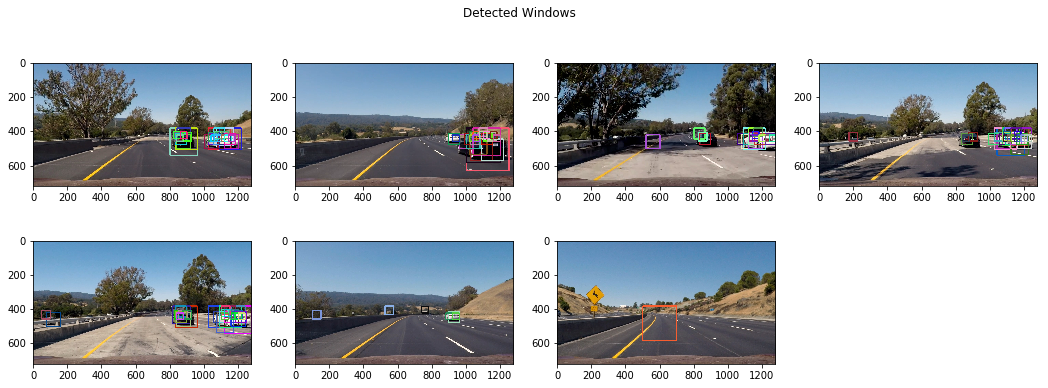

In [69]:
test_fn = glob("test_images/test*")
row = 2
col = 4
fig = plt.figure(figsize=(18,6))

for i, fn in enumerate(test_fn):
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    on_windows = search_windows(img, windows, svc, X_scaler)

    plt.subplot(row, col, i+1)
    window_img = draw_boxes(img, on_windows, color="random", thick=6) 
    plt.imshow(window_img)
    
#     fig.savefig("output_images/search_window.jpg")
plt.suptitle("Detected Windows")
fig.savefig("output_images/detected_window.jpg")
plt.show()

## Multiple Detections & False Positives

In [70]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, "Car {}".format(car_number),
                    bbox[0], font, 2, (255,255,255), 2)
    # Return the image
    return img

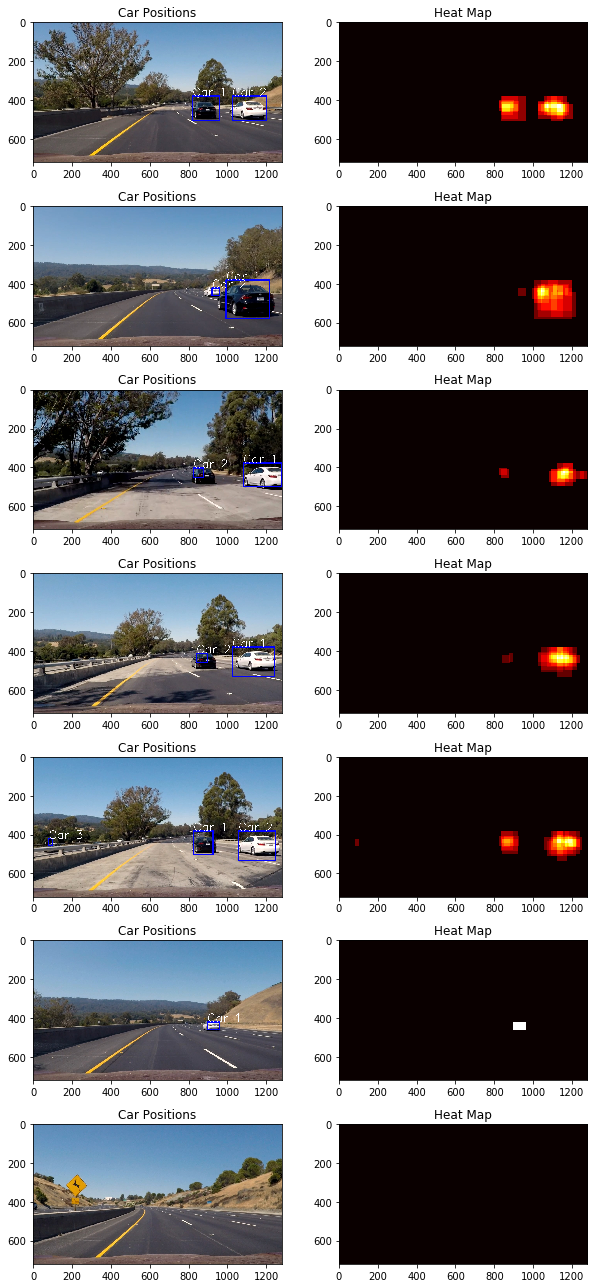

In [71]:
from scipy.ndimage.measurements import label

test_fn = glob("test_images/test*")
row = len(test_fn)
col = 2
fig = plt.figure(figsize=(9,18))
i = 0
for fn in test_fn:
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    on_windows = search_windows(img, windows, svc, X_scaler)

    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, on_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    i += 1
    plt.subplot(row, col, i)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    i += 1
    plt.subplot(row, col, i)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

#     plt.subplot(row, col, i+1)
#     window_img = draw_boxes(img, on_windows, color="random", thick=6) 
#     plt.imshow(window_img)
    
# plt.suptitle("Detected Windows")
fig.savefig("output_images/heatmap.jpg")
plt.show()

## Final Pipeline

In [72]:
heatmaps = []

def pipeline(img):
    on_windows = search_windows(img, windows, svc, X_scaler)

    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, on_windows)

    heatmaps.append(heat)
    if len(heatmaps) >= 10:
        heatmaps.pop(0)
    heat = np.ceil(np.mean(heatmaps, axis=0))

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

## Test Video

In [73]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip,CompositeVideoClip
from IPython.display import HTML

In [74]:
heatmaps = []
white_output = 'output_videos/test_video_out.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, preset="ultrafast")

[MoviePy] >>>> Building video output_videos/test_video_out.mp4
[MoviePy] Writing video output_videos/test_video_out.mp4



 97%|█████████▋| 38/39 [00:44<00:01,  1.16s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video_out.mp4 

CPU times: user 43.7 s, sys: 933 ms, total: 44.6 s
Wall time: 44.4 s


In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Project Video

In [ ]:
heatmaps = []
project_video_output = 'output_videos/project_video_out.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False, preset="ultrafast")

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


 65%|██████▌   | 825/1261 [16:09<08:27,  1.16s/it]

In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [60]:
composite_video_output = 'output_videos/composite_video_out.mp4'

clip1 = VideoFileClip(project_video_output)
clip2 = VideoFileClip("lane_detection_video.mp4")
clip1.set_opacity(0.5)
clip2.set_opacity(0.5)

video = CompositeVideoClip([clip1, clip2])
%time video.write_videofile(composite_video_output, audio=False,  threads=4, preset="ultrafast")

OSError: MoviePy error: failed to read the duration of file output_videos/project_video_out.mp4.
Here are the file infos returned by ffmpeg:

ffmpeg version 2.6.3-tessus Copyright (c) 2000-2015 the FFmpeg developers
  built with Apple LLVM version 6.0 (clang-600.0.57) (based on LLVM 3.5svn)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --as=yasm --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libass --enable-libbluray --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopus --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvidstab --enable-libvo-aacenc --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzmq --enable-version3 --disable-ffplay --disable-indev=qtkit --disable-indev=x11grab_xcb
  libavutil      54. 20.100 / 54. 20.100
  libavcodec     56. 26.100 / 56. 26.100
  libavformat    56. 25.101 / 56. 25.101
  libavdevice    56.  4.100 / 56.  4.100
  libavfilter     5. 11.102 /  5. 11.102
  libswscale      3.  1.101 /  3.  1.101
  libswresample   1.  1.100 /  1.  1.100
  libpostproc    53.  3.100 / 53.  3.100
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7fa822000600] moov atom not found
output_videos/project_video_out.mp4: Invalid data found when processing input
